Проект прогнозирования погоды на след день: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split

#cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from scipy import stats
from imblearn.over_sampling import SMOTE

import dill

In [12]:
data = pd.read_csv("weatherAUS.csv")
data.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No


In [13]:
data.shape

(145460, 23)

In [14]:
# в DF есть пропуски.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [15]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [16]:
# данные не сбалансированны по целевому признаку RainTomorrow
data['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [17]:
# процент пропусков
data.isnull().mean()*100

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [18]:
# Превратим в бинарный признак
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes': 1, 'No': 0})
data['RainToday'] = data['RainToday'].map({'Yes': 1, 'No': 0})

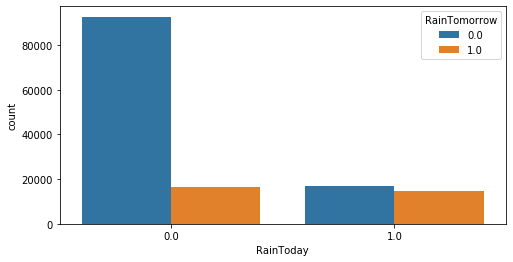

In [19]:
# проверим как зависит ключевая перенная от RainToday.
plt.figure(figsize = (8,4))
sns.countplot(x = 'RainToday', hue = 'RainTomorrow', data = data, linewidth = 1)

In [20]:
# Видно что обсюлюное большинство дней когда не случается дождя.Во всех остальных случаях нет явной зависмотсти.
# заменим пропускина наиболее часто встречающеся значение
data['RainTomorrow'] = data['RainTomorrow'].fillna(0)
data['RainToday'] = data['RainToday'].fillna(0)

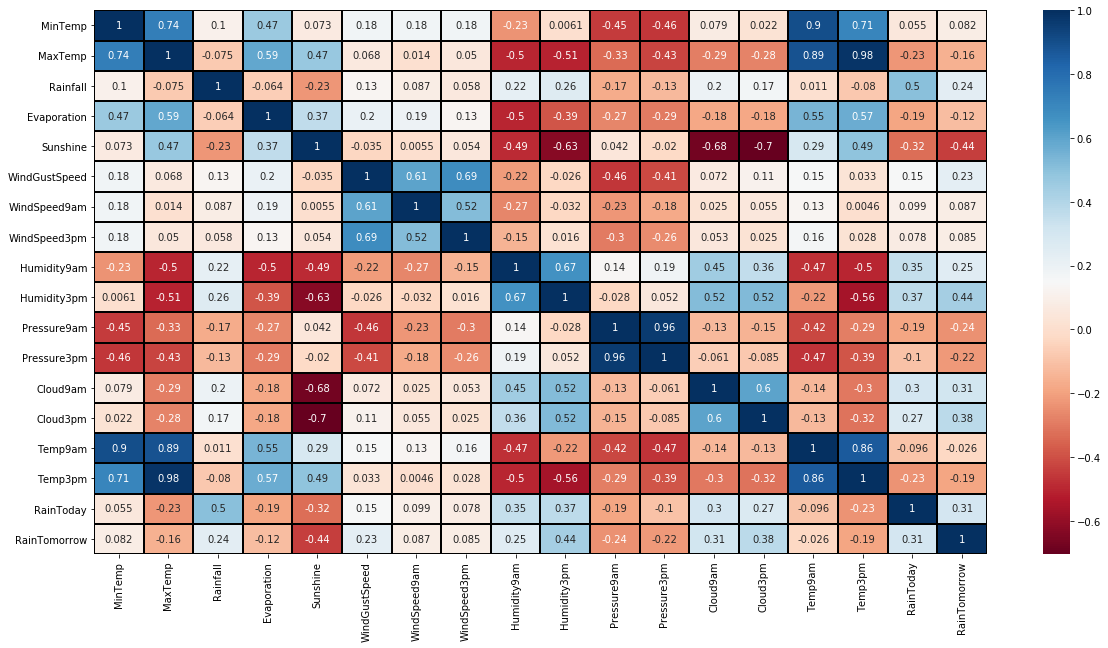

In [21]:
# посстроим кореляционную матрицу.
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(), cmap = 'RdBu', annot = True, linewidths=1, linecolor='black')

Заметим, что есть большая коллеряция между Максиммальной/минимальной температурой, температурой после 9-ти (думаю что один из признаков можно удалить или лучше уменьшить кол-во данных и превратить темературу в один признак). Так же видно, что есть корреляция между другими данными одного типа - облачность, давление и тд. полученные в разные периоды времени. Можно попробывать унифицировать

Так же вижим, 2 признака с большим кол-вом пробелов имеют разную корреляцию с целевым. "Sunshine" я бы удалил, т.к. относительно большая корреляция и очень много пропусков

In [22]:
data=data.drop(['Sunshine'], axis=1)

По остальным признаком пробелов не много. Заполним средними значениями или по моде(категориальные):

In [23]:
data['MinTemp']=data['MinTemp'].fillna(data['MinTemp'].mean())
data['MaxTemp']=data['MinTemp'].fillna(data['MaxTemp'].mean())
data['Rainfall']=data['Rainfall'].fillna(data['Rainfall'].mean())
data['Evaporation']=data['Evaporation'].fillna(data['Evaporation'].mean())
data['WindGustSpeed']=data['WindGustSpeed'].fillna(data['WindGustSpeed'].mean())
data['WindSpeed9am']=data['WindSpeed9am'].fillna(data['WindSpeed9am'].mean())
data['WindSpeed3pm']=data['WindSpeed3pm'].fillna(data['WindSpeed3pm'].mean())
data['Humidity9am']=data['Humidity9am'].fillna(data['Humidity9am'].mean())
data['Humidity3pm']=data['Humidity3pm'].fillna(data['Humidity3pm'].mean())
data['Pressure9am']=data['Pressure9am'].fillna(data['Pressure9am'].mean())
data['Pressure3pm']=data['Pressure3pm'].fillna(data['Pressure3pm'].mean())
data['Cloud9am']=data['Cloud9am'].fillna(data['Cloud9am'].mean())
data['Cloud3pm']=data['Cloud3pm'].fillna(data['Cloud3pm'].mean())
data['Temp9am']=data['Temp9am'].fillna(data['Temp9am'].mean())
data['Temp3pm']=data['Temp3pm'].fillna(data['Temp3pm'].mean())

In [24]:
data['WindDir9am'] = data['WindDir9am'].fillna(data['WindDir9am'].mode()[0])
data['WindGustDir'] = data['WindGustDir'].fillna(data['WindGustDir'].mode()[0])
data['WindDir3pm'] = data['WindDir3pm'].fillna(data['WindDir3pm'].mode()[0])

In [25]:
data.isnull().mean()*100

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [26]:
# Превратим категориальные призаки в числа (пока в новую колонку)
le = LabelEncoder()
data['Location_new'] = le.fit_transform(data['Location'])
data['WindDir9am_new'] = le.fit_transform(data['WindDir9am'])
data['WindDir3pm_new'] = le.fit_transform(data['WindDir3pm'])
data['WindGustDir_new'] = le.fit_transform(data['WindGustDir'])

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date             145460 non-null  object 
 1   Location         145460 non-null  object 
 2   MinTemp          145460 non-null  float64
 3   MaxTemp          145460 non-null  float64
 4   Rainfall         145460 non-null  float64
 5   Evaporation      145460 non-null  float64
 6   WindGustDir      145460 non-null  object 
 7   WindGustSpeed    145460 non-null  float64
 8   WindDir9am       145460 non-null  object 
 9   WindDir3pm       145460 non-null  object 
 10  WindSpeed9am     145460 non-null  float64
 11  WindSpeed3pm     145460 non-null  float64
 12  Humidity9am      145460 non-null  float64
 13  Humidity3pm      145460 non-null  float64
 14  Pressure9am      145460 non-null  float64
 15  Pressure3pm      145460 non-null  float64
 16  Cloud9am         145460 non-null  floa

## Работа с выбрасами

In [28]:
# разобьем колонки на категории.
columns_numer=data.select_dtypes(include=['float64']).columns #цифровые значения
columns_cat_new=data.select_dtypes(include=['int32']).columns #новые категории
columns_cat_old=data.select_dtypes(include=['object']).columns #старые категории
print(columns_numer)
print(columns_cat_new)
print(columns_cat_old)

# Тоже есть что подправить! но для анализа пока хватит

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
Index(['Location_new', 'WindDir9am_new', 'WindDir3pm_new', 'WindGustDir_new'], dtype='object')
Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')


In [29]:
# стандартизируем данные что бы было удобнее смотреть на наличие выбросов
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(data[columns_numer]))

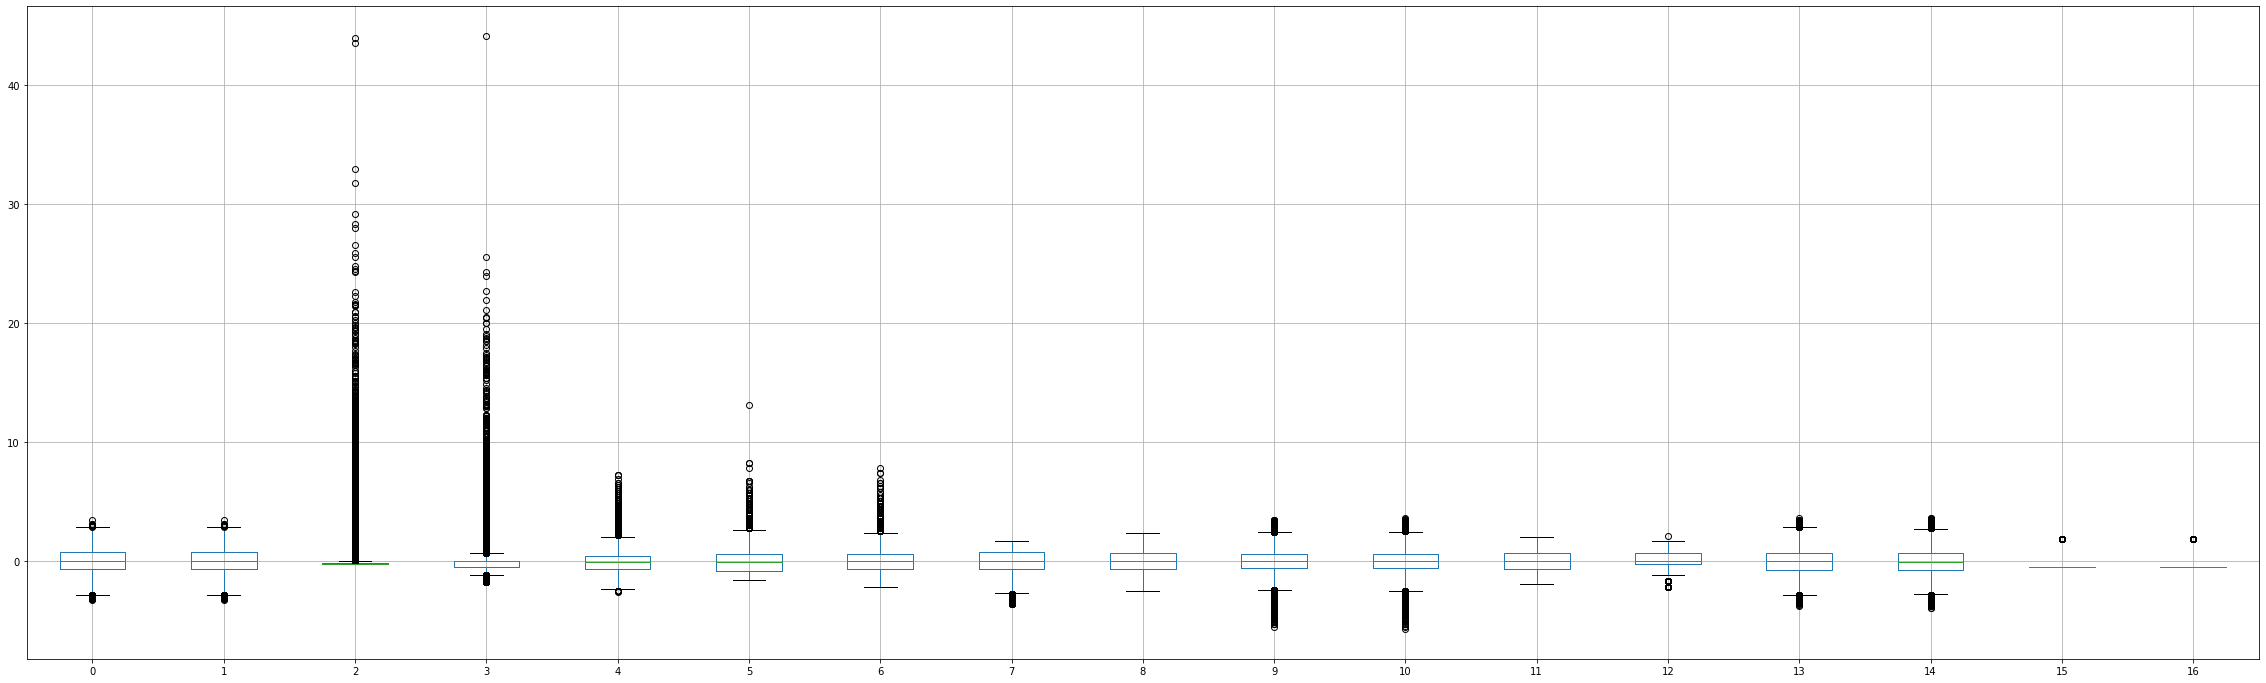

In [30]:
boxplot = df_scale.boxplot(figsize=(40, 12))

Видно что выбросов много. Можно попробовать удалить записи с выбросами или заменить на среднее например. 

In [31]:
# т.к. данных относительно много можно удалить записы с выбросами.
print('Размер до удаления', data.shape )
data=data[(np.abs(stats.zscore(data[columns_numer])) < 3).all(axis=1)]
print('Размер после удаления', data.shape )

Размер до удаления (145460, 26)
Размер после удаления (136653, 26)


Рамер не сильно уменьшился.

## Feature engineering

In [32]:
# построим новые признаки
data['Cloud_diff'] = data['Cloud3pm'] - data['Cloud9am']
data['WindSpeed_diff'] = data['WindSpeed3pm'] - data['WindSpeed9am']
data['Humidity_diff'] = data['Humidity3pm'] - data['Humidity9am']
data['Pressure_diff'] = data['Pressure3pm'] - data['Pressure9am']
data['Temp_diff']=data['Temp3pm'] - data['Temp9am']
data.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,RainTomorrow,Location_new,WindDir9am_new,WindDir3pm_new,WindGustDir_new,Cloud_diff,WindSpeed_diff,Humidity_diff,Pressure_diff,Temp_diff
0,2008-12-01,Albury,13.4,13.4,0.6,5.468232,W,44.0,W,WNW,...,0.0,2,13,14,13,-3.490070,4.0,-49.0,-0.6,4.9
1,2008-12-02,Albury,7.4,7.4,0.0,5.468232,WNW,44.0,NNW,WSW,...,0.0,2,6,15,14,0.062469,18.0,-19.0,-2.8,7.1
2,2008-12-03,Albury,12.9,12.9,0.0,5.468232,WSW,46.0,W,WSW,...,0.0,2,13,15,15,-2.447461,7.0,-8.0,1.1,2.2


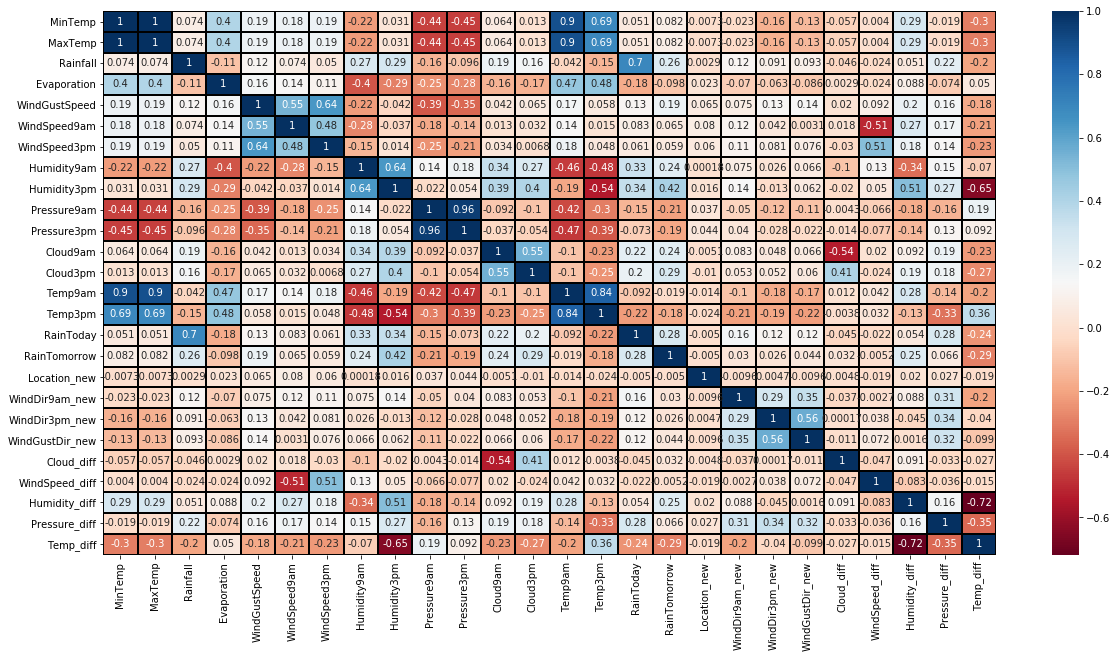

In [33]:
# посстроим кореляционную матрицу.
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(), cmap = 'RdBu', annot = True, linewidths=1, linecolor='black')

В целом можно снизить кол-во призаков. При этом корреляция в некоторых местах осталась. Сильно коррелировнный признаки  можно удалить.

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136653 entries, 0 to 145459
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date             136653 non-null  object 
 1   Location         136653 non-null  object 
 2   MinTemp          136653 non-null  float64
 3   MaxTemp          136653 non-null  float64
 4   Rainfall         136653 non-null  float64
 5   Evaporation      136653 non-null  float64
 6   WindGustDir      136653 non-null  object 
 7   WindGustSpeed    136653 non-null  float64
 8   WindDir9am       136653 non-null  object 
 9   WindDir3pm       136653 non-null  object 
 10  WindSpeed9am     136653 non-null  float64
 11  WindSpeed3pm     136653 non-null  float64
 12  Humidity9am      136653 non-null  float64
 13  Humidity3pm      136653 non-null  float64
 14  Pressure9am      136653 non-null  float64
 15  Pressure3pm      136653 non-null  float64
 16  Cloud9am         136653 non-null  floa

In [35]:
# Собираем колонки
columns_numer=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed', 'RainToday']
columns_numer_two=['WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm']
columns_cat_new=['Location_new', 'WindDir9am_new', 'WindDir3pm_new', 'WindGustDir_new']
columns_cat_old=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
columns_numer_new=['Cloud_diff', 'WindSpeed_diff', 'Humidity_diff', 'Pressure_diff', 'Temp_diff']
Predict_fich=['RainTomorrow']

In [36]:
data[columns_numer+columns_numer_two+columns_cat_new+columns_numer_new]

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,RainToday,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp3pm,Location_new,WindDir9am_new,WindDir3pm_new,WindGustDir_new,Cloud_diff,WindSpeed_diff,Humidity_diff,Pressure_diff,Temp_diff
0,13.4,13.4,0.6,5.468232,44.00000,0.0,20.0,24.0,71.0,22.0,...,21.8,2,13,14,13,-3.490070,4.0,-49.0,-0.6,4.9
1,7.4,7.4,0.0,5.468232,44.00000,0.0,4.0,22.0,44.0,25.0,...,24.3,2,6,15,14,0.062469,18.0,-19.0,-2.8,7.1
2,12.9,12.9,0.0,5.468232,46.00000,0.0,19.0,26.0,38.0,30.0,...,23.2,2,13,15,15,-2.447461,7.0,-8.0,1.1,2.2
3,9.2,9.2,0.0,5.468232,24.00000,0.0,11.0,9.0,45.0,16.0,...,26.5,2,9,0,4,0.062469,-2.0,-29.0,-4.8,8.4
4,17.5,17.5,1.0,5.468232,41.00000,0.0,7.0,20.0,82.0,33.0,...,29.7,2,1,7,13,1.000000,13.0,-49.0,-4.8,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,2.8,0.0,5.468232,31.00000,0.0,13.0,11.0,51.0,24.0,...,22.4,41,9,1,0,0.062469,-2.0,-27.0,-4.3,12.3
145456,3.6,3.6,0.0,5.468232,22.00000,0.0,13.0,9.0,56.0,21.0,...,24.5,41,9,3,6,0.062469,-4.0,-35.0,-4.4,13.6
145457,5.4,5.4,0.0,5.468232,37.00000,0.0,9.0,9.0,53.0,24.0,...,26.1,41,9,14,3,0.062469,0.0,-29.0,-4.2,13.6
145458,7.8,7.8,0.0,5.468232,28.00000,0.0,13.0,7.0,51.0,24.0,...,26.0,41,10,3,9,-1.000000,-6.0,-27.0,-2.9,10.9


## Балансировки классов Smote
Т.к. у нас цулевой призхнак не сбалансирован, то испольщуем метод SMOTE для балнсировки

In [37]:
os = SMOTE()
x, y = os.fit_resample(data[columns_numer+columns_numer_two+columns_cat_new+columns_numer_new], data[Predict_fich])
y['RainTomorrow'].value_counts()

1.0    108503
0.0    108503
Name: RainTomorrow, dtype: int64

In [38]:
x.shape

(217006, 25)

In [39]:
# Нормализуем
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x))

### Построение модели

In [40]:
def otchet (y_test, y_predict):
    print('Confusion Matrix:',"\n")
    print(confusion_matrix(y_test,predicted),"\n")
    print('roc_auc =', roc_auc_score(y_test, predicted),"\n")
    print('classification_report:',"\n")
    print(classification_report(y_test,predicted),"\n")
    return print('-'*60)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [42]:
# LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(x_train, y_train)
predicted=model.predict(x_test)

otchet(y_test, predicted)

E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion Matrix: 

[[16795  4815]
 [ 5368 16424]] 

roc_auc = 0.7654287798450845 

classification_report: 

              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77     21610
         1.0       0.77      0.75      0.76     21792

    accuracy                           0.77     43402
   macro avg       0.77      0.77      0.77     43402
weighted avg       0.77      0.77      0.77     43402
 

------------------------------------------------------------


In [43]:
# XGBClassifier
xgbc = XGBClassifier(objective='binary:logistic')
xgbc.fit(x_train,y_train)
predicted = xgbc.predict(x_test)

otchet(y_test, predicted)

E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion Matrix: 

[[20266  1344]
 [ 2673 19119]] 

roc_auc = 0.9075734397009869 

classification_report: 

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     21610
         1.0       0.93      0.88      0.90     21792

    accuracy                           0.91     43402
   macro avg       0.91      0.91      0.91     43402
weighted avg       0.91      0.91      0.91     43402
 

------------------------------------------------------------


In [44]:
#RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth=13)  
rfc.fit(x_train, y_train)  
predicted = rfc.predict(x_test)
otchet(y_test, predicted)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix: 

[[18990  2620]
 [ 3216 18576]] 

roc_auc = 0.8655913704497225 

classification_report: 

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87     21610
         1.0       0.88      0.85      0.86     21792

    accuracy                           0.87     43402
   macro avg       0.87      0.87      0.87     43402
weighted avg       0.87      0.87      0.87     43402
 

------------------------------------------------------------


In [45]:
# Усреднение с весами.
new_mod= VotingClassifier(estimators=[('lr', model), ('xgbc', xgbc), ('rfc', rfc)], voting='soft', weights=[1,2,1])
new_mod = new_mod.fit(x_train, y_train)
predicted=new_mod.predict(x_test)

otchet(y_test, predicted)

E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion Matrix: 

[[19571  2039]
 [ 2334 19458]] 

roc_auc = 0.8992710051228527 

classification_report: 

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     21610
         1.0       0.91      0.89      0.90     21792

    accuracy                           0.90     43402
   macro avg       0.90      0.90      0.90     43402
weighted avg       0.90      0.90      0.90     43402
 

------------------------------------------------------------


In [46]:
# Воспользуемся усреднением.
t1 = model.predict_proba(x_test)[:,1]
t2 = xgbc.predict_proba(x_test)[:,1]
t3 = rfc.predict_proba(x_test)[:,1]
t4=new_mod.predict_proba(x_test)[:,1]

In [47]:
result=y_test.copy()

In [48]:
result['LR']=t1
result['XGBC']=t2
result['RFC']=t3
result['Объединение с весами']=t4
result['LR_XGBC_RFC'] = result[['LR', 'XGBC', 'RFC']].mean(axis=1)
result['LG_XGBC'] = result[['LR', 'XGBC']].mean(axis=1)
result['XGBC_RFC'] = result[['XGBC', 'RFC']].mean(axis=1)
result['LR_RFC'] = result[['LR', 'RFC']].mean(axis=1)
result

,RainTomorrow,LR,XGBC,RFC,Объединение с весами,LR_XGBC_RFC,LG_XGBC,XGBC_RFC,LR_RFC
179069,1.0,0.775118,0.981955,0.935814,0.918711,0.897629,0.878537,0.958885,0.855466
123200,0.0,0.568033,0.265595,0.510552,0.402444,0.448060,0.416814,0.388074,0.539293
190092,1.0,0.969652,0.999833,0.980165,0.987371,0.983217,0.984742,0.989999,0.974909
21356,1.0,0.660106,0.249463,0.463122,0.405538,0.457564,0.454784,0.356293,0.561614
81600,0.0,0.187394,0.069348,0.101731,0.106955,0.119491,0.128371,0.085539,0.144563
...,...,...,...,...,...,...,...,...,...
126611,0.0,0.614076,0.547879,0.630228,0.585015,0.597394,0.580977,0.589053,0.622152
80017,1.0,0.249580,0.167291,0.303509,0.221918,0.240127,0.208436,0.235400,0.276544
115866,0.0,0.130623,0.157985,0.262307,0.177225,0.183639,0.144304,0.210146,0.196465
170941,1.0,0.852450,0.998582,0.818377,0.916998,0.889803,0.925516,0.908480,0.835414


In [49]:
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                            roc_auc_score(y_test, probs)))
    return thresholds[ix]

In [50]:
for col in result.columns[1:]:
    print('Колонка', col,' ----->', end='')
    k=get_metrics(result[col])
    

Колонка LR  ----->Best Threshold=0.358990, F-Score=0.782, Precision=0.712, Recall=0.866, Roc-AUC=0.851
Колонка XGBC  ----->Best Threshold=0.499134, F-Score=0.905, Precision=0.934, Recall=0.878, Roc-AUC=0.966
Колонка RFC  ----->Best Threshold=0.452592, F-Score=0.868, Precision=0.854, Recall=0.882, Roc-AUC=0.942
Колонка Объединение с весами  ----->Best Threshold=0.521208, F-Score=0.900, Precision=0.914, Recall=0.886, Roc-AUC=0.960
Колонка LR_XGBC_RFC  ----->Best Threshold=0.499724, F-Score=0.888, Precision=0.888, Recall=0.888, Roc-AUC=0.952
Колонка LG_XGBC  ----->Best Threshold=0.527315, F-Score=0.894, Precision=0.901, Recall=0.887, Roc-AUC=0.951
Колонка XGBC_RFC  ----->Best Threshold=0.481986, F-Score=0.902, Precision=0.911, Recall=0.893, Roc-AUC=0.964
Колонка LR_RFC  ----->Best Threshold=0.434707, F-Score=0.839, Precision=0.802, Recall=0.879, Roc-AUC=0.914


Берем наилучшую оценку по _roc-AUC_ Т.е. XGBClassifier

In [54]:
with open("xgbc_smote.dill", "wb") as f:
    dill.dump(xgbc, f)